## Useful Functions

In [264]:
def get_model( temp ):
    '''
    Function opens Phoenix file of specified temperature in 100 Kelvin increments from 2300 to 12000 Kelvin.
    Parameters
    ----------
    temp: str
        Desired temperature in 100K increments from 2300 to 12,000 Kelvin
        
    Returns
    -------
    wavelength: array
        Associated wavelengths for flux measurements from Phoenix FITS file, in Angstroms
        
    flux: array
        Flux measurements from Phoenix FITS file, in erg/s/cm^2
        
    temp: str
        See Parameters
    '''
    model_file = 'Extinction Vector Project/Med_Res_10K_Grid/lte0' + temp + '-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    #what are the numbers here? -4.50-0.0
    hdulist = fits.open(model_file)
    flux = hdulist[0].data
    wavelength = np.exp(hdulist[0].header[('CRVAL1')]+hdulist[0].header[('CDELT1')]*np.arange(0,212027))/(10**4)
    return wavelength,flux

In [265]:
def getFMext(x,R):
    
    """ Fitzpatrick 1999, spectroscopic

        Inputs:  x = inverse wavelength in microns
                 R = ratio of A_V to E(B-V)
                
        Outputs:  returns Al/AV in magnitude units
    """
    
    from scipy.interpolate import interp1d
    
    import numpy as np

    f99_anchor = 1.0E4 / np.array([np.inf, 26500., 12200., 6000., 5470., 4670., 4110., 2700., 2600.]) #microns
    #np.array creates an array
    #np.inf sets value to infinity
    #"anchor" wavelengths for the function to come--what is the pattern here?
    #x axis values
    
    a6000=-0.426+1.0044*R
    a5470=-0.050+1.0016*R
    a4670= 0.701+1.0016*R
    a4110= 1.208+1.0032*R-0.00033*R**2
    #for values in array, apply R in some way
    #create new values using R. Where do coefficients of R come from?

    af99_anchor = np.array([0.0, 0.265, 0.829, a6000, a5470, a4670, a4110, 6.265, 6.591])/3.1
    #same shape as previous array so function can be created
    #create a new array, replacing numbers from original array with their corresponding constant
    #divide by 3.1: comparing to the "standard" R value of 3.1?
    #y axis values--tell extinction pattern of "anchor values"?
    
    f=interp1d(f99_anchor,af99_anchor, kind='cubic') 
    #create a 2-variable function between the two arrays, wavelength and magnitude of extinction
    #find a function of frequency (1/wavelength)
    
    return f(x)
    #A_lambda/A_V:a different value for each input wavelength (continuous function)

In [266]:
def PlotExtinguishedSpectrum(temp,extinction,R,scale,bbtemp,bbscale):
    
    model_wavelengths = get_model(temp)[0]
    model_spectrum = scale*(get_model(temp)[1])/10000/10000
    Al_over_Av = getFMext(1.0/model_wavelengths, R)
    
    bbwavelengths = wav #microns #list of all wavelengths
    bbflux = (planck_sed(wav,bbtemp)) #list of corresponding fluxes
    fluxdist=bbscale*bbflux
    blackbodyf= interp1d(bbwavelengths, fluxdist)
    totalflux= model_spectrum + blackbodyf(model_wavelengths)
    
    extinguished_spectrum = model_spectrum*10.0**(-0.4*Al_over_Av*extinction) + blackbodyf(model_wavelengths)
    
    plt.plot(model_wavelengths,extinguished_spectrum)

In [267]:
def PlotExtinguishedBBToo(temp,extinction,R,scale,bbtemp,bbscale):
    model_wavelengths = get_model(temp)[0]
    model_spectrum = scale*(get_model(temp)[1])/10000/10000
    Al_over_Av = getFMext(1.0/model_wavelengths, R)
    
    bbwavelengths = wav #microns #list of all wavelengths
    bbflux = (planck_sed(wav,bbtemp)) #list of corresponding fluxes
    fluxdist=bbscale*bbflux
    blackbodyf= interp1d(bbwavelengths, fluxdist)
    totalflux= model_spectrum + blackbodyf(model_wavelengths)
    
    extinguished_spectrum = totalflux*10.0**(-0.4*Al_over_Av*extinction)
    
    plt.plot(model_wavelengths,extinguished_spectrum)

In [268]:
def PlotSpectrumData(filename,columns):
    modelfile = filename
    wavelength, flux = np.loadtxt(filename, usecols=columns, skiprows=0, unpack=True)
    plt.plot(wavelength,flux)
    

In [269]:
def PlotSpectrumDataScale(filename,columns,scale):
    modelfile = filename
    wavelength, flux = np.loadtxt(filename, usecols=columns, skiprows=0, unpack=True)
    plt.plot(wavelength,scale*flux)
    

In [270]:
def PlotSpectrumBB(filename,columns,bbtemp,bbscale):
    modelfile = filename
    wavelength, flux = np.loadtxt(filename, usecols=columns, skiprows=0, unpack=True)
    
    bbwavelengths = wav #microns #list of all wavelengths
    bbflux = (planck_sed(wav,bbtemp)) #list of corresponding fluxes
    fluxdist=bbscale*bbflux
    blackbodyf= interp1d(bbwavelengths, fluxdist)
    totalflux= flux + blackbodyf(wavelengths)

    plt.plot(wavelength,totalflux)

In [271]:
import numpy as np
dwav=0.001
wav=np.arange(0.29,2.51,dwav) #wavelength = microns #range of PHOENIX spectra is 0.3 to 2.5 microns

def planck_sed(wav,T):
# Source blackbody emission: wavelength in microns, temp in Kelvin
# Output is SED (Spectral Energy Distribution)
# Units are SI W/m^2/m

    l=wav*1E-6
    h=6.62606957*(10**-34.0)
    c=3.00*(10**8.0)
    k=1.3806488*(10**-23.0)
    
    x=(2.0*3.14*h*c**2.0/l**5.0)
    
    exponent = h*c/(k*T*l)
                 
    ex = np.exp(exponent)-1

    PLANCK=(x)*(ex**-1)
    
    return PLANCK*(10**7)/10000/(10**10)

In [272]:
import numpy as np
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from scipy.interpolate import interp1d

from astropy.io import fits

%matplotlib inline

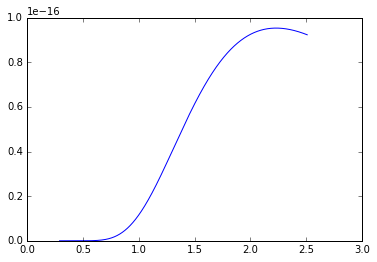

In [273]:
bbwavelengths = wav #microns #list of all wavelengths
bbflux = (planck_sed(wav,1300)) #list of corresponding fluxes

blackbodyf= interp1d(bbwavelengths, bbflux)
plt.plot(bbwavelengths,0.2*10**-19*bbflux)

# Method 1

Model temperature: 4000K

A_V: 3

R_V = 2.0

Model scale: 1.1(10^-19)

Blackbody temperature: 2500K

Blackbody scale: 0.6(10^-19)

Optical spectrum scale: 1.1

IR spectrum scale: 1

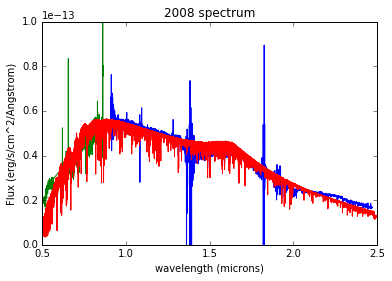

In [275]:
PlotSpectrumData('Extinction Vector Project/testingspectra/AA_Tau/AATau_IR2008.txt',(0,1))
PlotSpectrumDataScale('Extinction Vector Project/testingspectra/AA_Tau/AATau_opt2008.txt',(0,1),1.1)

PlotExtinguishedSpectrum('4000',3,2.0,1.1*10**-19,2500,0.6*10**-19)

#plt.plot(bbwavelengths,0.5*10**-19*bbflux)

axes = plt.gca()
axes.set_ylim([0,10**-13])
axes.set_xlim([0.5,2.5])

plt.xlabel("wavelength (microns)")
plt.ylabel("Flux (erg/s/cm^2/Angstrom)")
plt.title("2008 spectrum")

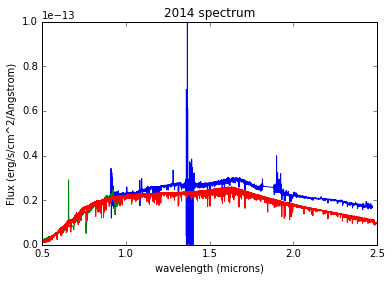

In [276]:
PlotSpectrumData('Extinction Vector Project/testingspectra/AA_Tau/AATau_IR2014.txt',(0,1))
PlotSpectrumDataScale('Extinction Vector Project/testingspectra/AA_Tau/AATau_opt2014.txt',(0,1),1.1)

PlotExtinguishedSpectrum('4000',7,2.0,1.1*10**-19,2500,0.6*10**-19)

#plt.plot(bbwavelengths,0.5*10**-19*bbflux)

axes = plt.gca()
axes.set_ylim([0,10**-13])
axes.set_xlim([0.5,2.5])

plt.xlabel("wavelength (microns)")
plt.ylabel("Flux (erg/s/cm^2/Angstrom)")
plt.title("2014 spectrum")

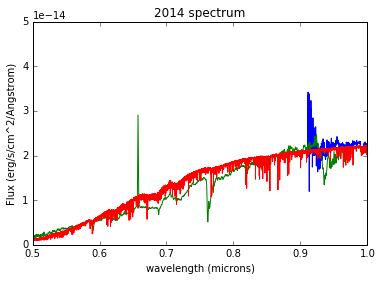

In [277]:
PlotSpectrumData('Extinction Vector Project/testingspectra/AA_Tau/AATau_IR2014.txt',(0,1))
PlotSpectrumDataScale('Extinction Vector Project/testingspectra/AA_Tau/AATau_opt2014.txt',(0,1),1.1)

PlotExtinguishedSpectrum('4000',7,2.0,1.1*10**-19,2500,0.6*10**-19)

#plt.plot(bbwavelengths,0.5*10**-19*bbflux)

axes = plt.gca()
axes.set_ylim([0,0.5*10**-13])
axes.set_xlim([0.5,1.0])

plt.xlabel("wavelength (microns)")
plt.ylabel("Flux (erg/s/cm^2/Angstrom)")
plt.title("2014 spectrum")

# Method 2

Model temperature: 4000K

A_V: 3.65

R_V = 2.0

Model scale: 1.1(10^-19)

Blackbody temperature: 2500K

Blackbody scale: 0.35(10^-19)

Optical spectrum scale: 1

IR spectrum scale: 0.8

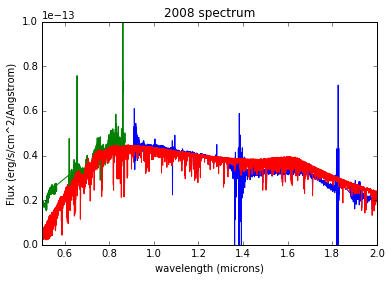

In [278]:
PlotSpectrumDataScale('Extinction Vector Project/testingspectra/AA_Tau/AATau_IR2008.txt',(0,1),0.8)
PlotSpectrumData('Extinction Vector Project/testingspectra/AA_Tau/AATau_opt2008.txt',(0,1))
PlotExtinguishedSpectrum('4000',3.65,2.0,1.1*10**-19,2500,0.35*10**-19)

#plt.plot(bbwavelengths,0.5*10**-19*bbflux)

axes = plt.gca()
axes.set_ylim([0,1*10**-13])
axes.set_xlim([0.5,2.0])

plt.xlabel("wavelength (microns)")
plt.ylabel("Flux (erg/s/cm^2/Angstrom)")
plt.title("2008 spectrum")

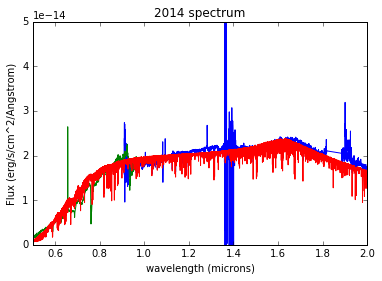

In [279]:
PlotSpectrumDataScale('Extinction Vector Project/testingspectra/AA_Tau/AATau_IR2014.txt',(0,1),0.8)
PlotSpectrumData('Extinction Vector Project/testingspectra/AA_Tau/AATau_opt2014.txt',(0,1))
PlotExtinguishedSpectrum('4000',6.9,2.0,1.1*10**-19,2500,0.35*10**-19)

#plt.plot(bbwavelengths,0.5*10**-19*bbflux)

axes = plt.gca()
axes.set_ylim([0,0.5*10**-13])
axes.set_xlim([0.5,2.0])
plt.xlabel("wavelength (microns)")
plt.ylabel("Flux (erg/s/cm^2/Angstrom)")
plt.title("2014 spectrum")

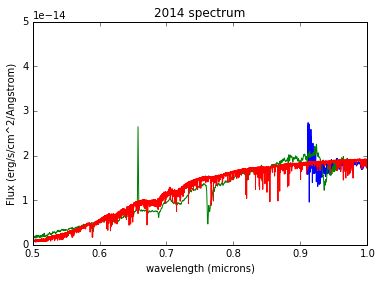

In [280]:
PlotSpectrumDataScale('Extinction Vector Project/testingspectra/AA_Tau/AATau_IR2014.txt',(0,1),0.8)
PlotSpectrumData('Extinction Vector Project/testingspectra/AA_Tau/AATau_opt2014.txt',(0,1))
PlotExtinguishedSpectrum('4000',7,2.0,1.1*10**-19,2500,0.35*10**-19)

#plt.plot(bbwavelengths,0.5*10**-19*bbflux)

axes = plt.gca()
axes.set_ylim([0,0.5*10**-13])
axes.set_xlim([0.5,1.0])

plt.xlabel("wavelength (microns)")
plt.ylabel("Flux (erg/s/cm^2/Angstrom)")
plt.title("2014 spectrum")

# Method 3

Model temperature: 4000K

A_V: 2.9

R_V = 2.0

Model scale: 1.1(10^-19)

No blackbody

Optical spectrum scale: 1.1

IR spectrum scale: 0.8

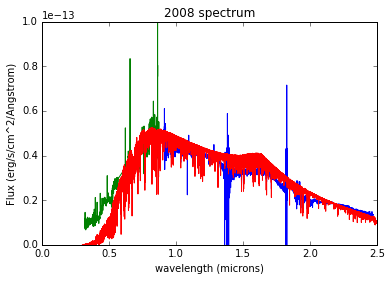

In [281]:
PlotSpectrumDataScale('Extinction Vector Project/testingspectra/AA_Tau/AATau_IR2008.txt',(0,1),0.8)
PlotSpectrumDataScale('Extinction Vector Project/testingspectra/AA_Tau/AATau_opt2008.txt',(0,1),1.1)

PlotExtinguishedSpectrum('4000',2.9,2.0,1.1*10**-19,2500,0.0*10**-19)

#plt.plot(bbwavelengths,0.5*10**-19*bbflux)

axes = plt.gca()
axes.set_ylim([0,10**-13])
axes.set_xlim([0.0,2.5])

plt.xlabel("wavelength (microns)")
plt.ylabel("Flux (erg/s/cm^2/Angstrom)")
plt.title("2008 spectrum")

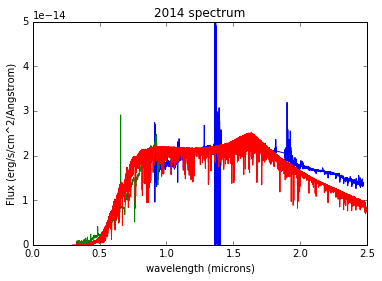

In [282]:
PlotSpectrumDataScale('Extinction Vector Project/testingspectra/AA_Tau/AATau_IR2014.txt',(0,1),0.8)
PlotSpectrumDataScale('Extinction Vector Project/testingspectra/AA_Tau/AATau_opt2014.txt',(0,1),1.1)

PlotExtinguishedSpectrum('4000',5.7,2.0,1.1*10**-19,2500,0.0*10**-19)

#plt.plot(bbwavelengths,0.5*10**-19*bbflux)

axes = plt.gca()
axes.set_ylim([0,0.5*10**-13])
axes.set_xlim([0.0,2.5])

plt.xlabel("wavelength (microns)")
plt.ylabel("Flux (erg/s/cm^2/Angstrom)")
plt.title("2014 spectrum")

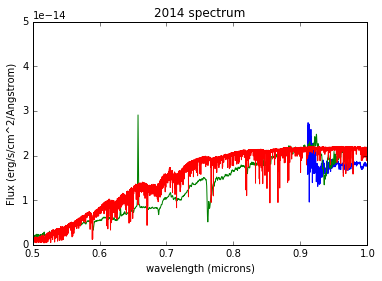

In [283]:
PlotSpectrumDataScale('Extinction Vector Project/testingspectra/AA_Tau/AATau_IR2014.txt',(0,1),0.8)
PlotSpectrumDataScale('Extinction Vector Project/testingspectra/AA_Tau/AATau_opt2014.txt',(0,1),1.1)

PlotExtinguishedSpectrum('4000',5.7,2.0,1.1*10**-19,2500,0.0*10**-19)

#plt.plot(bbwavelengths,0.5*10**-19*bbflux)

axes = plt.gca()
axes.set_ylim([0,0.5*10**-13])
axes.set_xlim([0.5,1.])

plt.xlabel("wavelength (microns)")
plt.ylabel("Flux (erg/s/cm^2/Angstrom)")
plt.title("2014 spectrum")